# kNN & Clustering

__Суммарное количество баллов: 10__

## kNN и рак (3 балла)

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas

from sklearn.model_selection import train_test_split as test_split
from sklearn.neighbors import KNeighborsClassifier as KNearestCl

### 1. Данные (0.5 балла)


Реализуйте метод `read_cancer_dataset` . Он принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [2]:
CANCER_DATA_PATH = "./hw2_data/cancer.csv"

In [3]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    cancer_csv = pd.read_csv(path_to_csv)
    X = cancer_csv.values[:, 1:]
    y = cancer_csv.values[:, 0]
    y[y == "M"] = 0
    y[y == "B"] = 1
    y=y.astype('int')
    return X, y

In [4]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)

In [5]:
# X_cancer

In [6]:
# y_cancer

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.7`.

In [7]:
def train_test_split(X, y, ratio = 0.7):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    X_train, X_test, y_train, y_test = test_split(X, y, train_size = ratio, random_state = 42, shuffle = True, stratify = None)
        
    return X_train, y_train, X_test, y_test

In [8]:
X_cancer_train, y_cancer_train, X_cancer_test, y_cancer_test = train_test_split(X_cancer, y_cancer)

In [9]:
y_cancer_test

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1])

### 2. Метрики (0.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [10]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    values = np.unique(y_pred)
    precision, recall = [], []
    for value in values:
        TP, TN, FP, FN = 0, 0, 0, 0
        for i in range(len(y_pred)):
            if y_pred[i] == value and y_true[i] == value:
                TP += 1
            elif y_pred[i] != value and y_true[i] == value:
                FN += 1
            elif y_pred[i] == value and y_true[i] != value:
                FP += 1
            else:
                TN += 1
        precision.append(TP / (TP + TN))
        recall.append(TP / (TP + FN))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [11]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearestCl(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

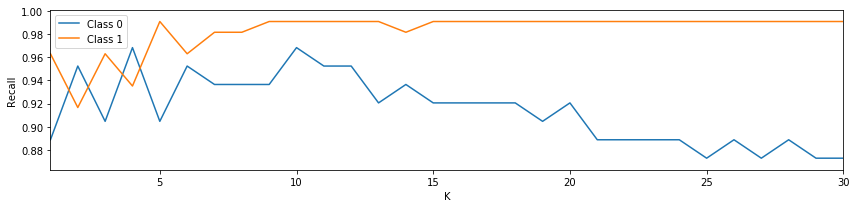

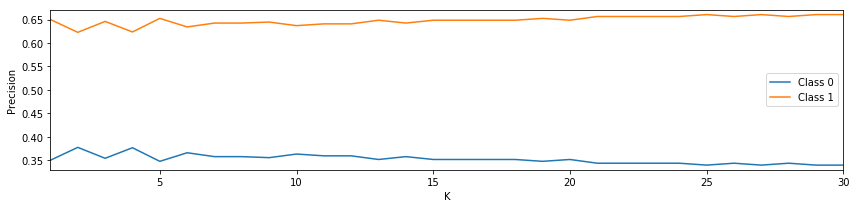

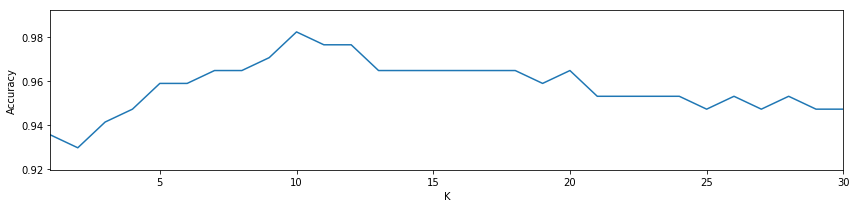

In [12]:
plot_precision_recall(X_cancer_train, y_cancer_train, X_cancer_test, y_cancer_test)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [13]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearestCl(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

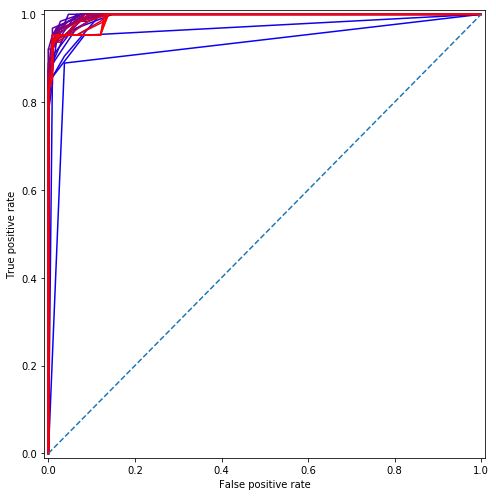

In [14]:
plot_roc_curve(X_cancer_train, y_cancer_train, X_cancer_test, y_cancer_test)

## 3. KNN (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [15]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.classifier = KNearestCl(n_neighbors=self.n_neighbors, leaf_size=self.leaf_size) 
    
    def fit(self, X, y):
        self.y = y
        self.X = X
        self.classifier.fit(X, y)
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
        raise self.classifier.predict_proba(X)
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на датасете _cancer_

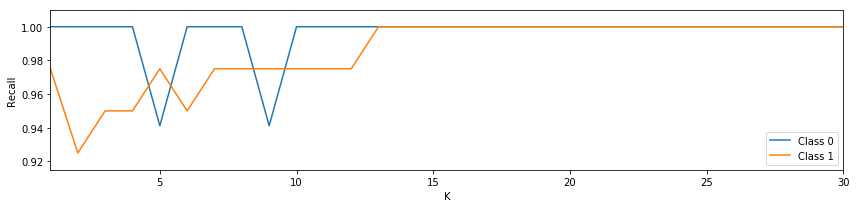

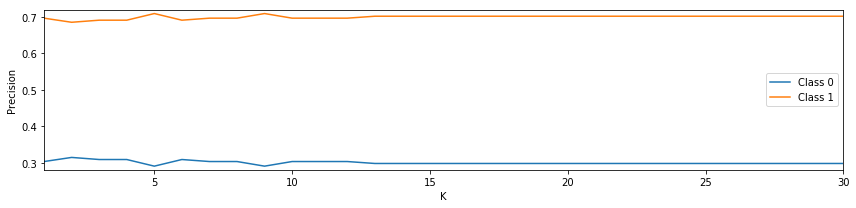

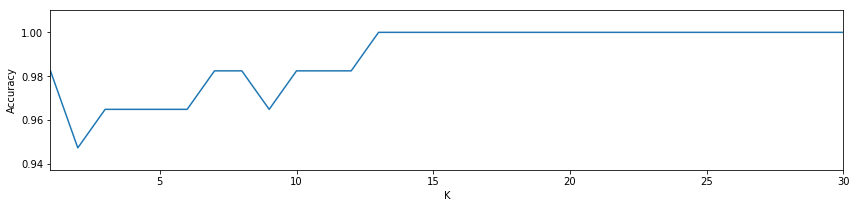

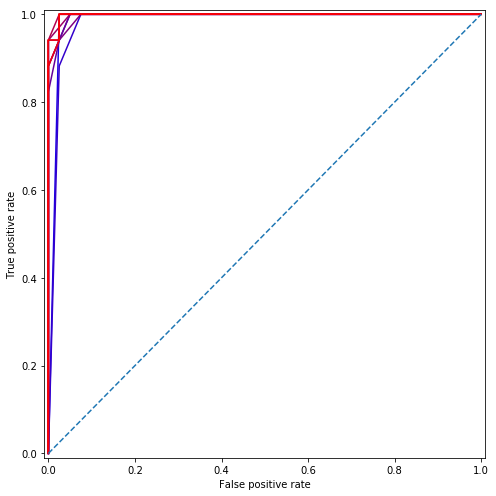

In [16]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)



Проанализируйте полученные графики. Какой параметр `k` кажется лучшим? Какая из метрик лучше всего отражает качество модели? 

> ROC-кривая выглядит очень оптимистично, она не просто сильно выше побочной диагонали, но почти прижимается к границам. Это говорит о хорошем качестве обученной модели. Мне кажется, что для первой задачи оптимальное значение K либо 6-7, либо 10-11. По графику Recall сложно что-то сказать, он очень прыгает. Вероятно в тех случаях, где падение, центры попадали между кластерами. Precision даёт мало информации, потому что он почти не меняется, а accuracy более-менее монотонна

## Clustering (7 баллов)

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [17]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
# import cv2
from collections import deque

In [18]:
# !pip install cv2

In [19]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

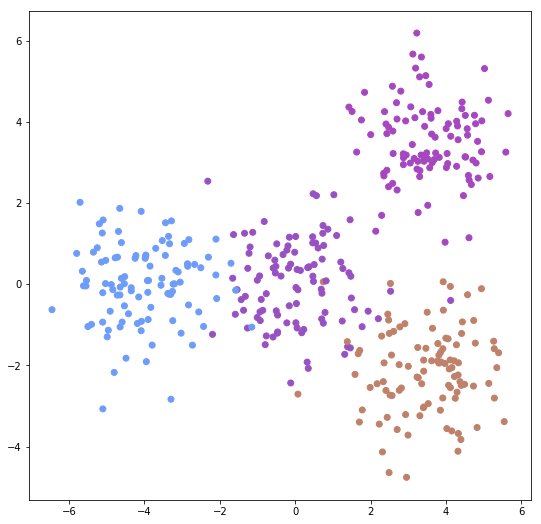

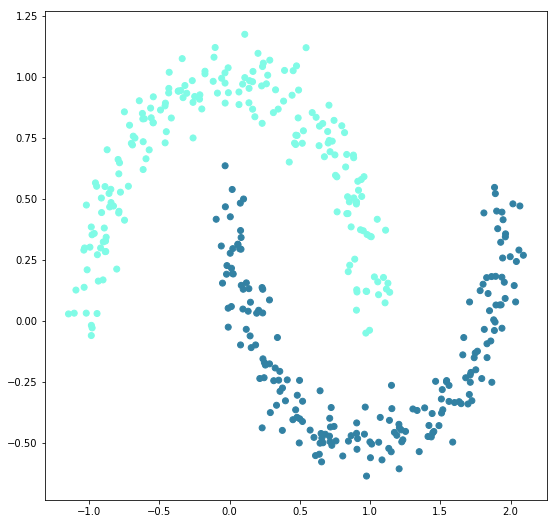

In [20]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### 1. K-means (2.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [21]:
from scipy.spatial import distance

In [22]:
np.random.seed(42)

class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        
    def fit(self, X, y=None):
        lower = np.amin(X[:, 1])
        upper = np.amax(X[:, 1])
        left = np.amin(X[:, 0])
        right = np.amax(X[:, 0])
        
        self.centroids = np.zeros(shape=(self.n_clusters, 2))
        
        if self.init == "random":
            for i in range(self.n_clusters):
                self.centroids[i] = [random.uniform(left, right), random.uniform(lower, upper)]
                
        elif self.init == "sample":
            for i in range(self.n_clusters):
                self.centroids[i] = X[random.randrange(X.shape[0])]
                                
        elif self.init == "k-means++":
            self.centroids[0] = X[random.randrange(0, X.shape[0])]
            probs = [(upper-lower)**2 + (left - right)**2 + 1] * X.shape[0]
            for it in range(self.n_clusters - 1):
                for i in range(X.shape[0]):
                    probs[i] = min(probs[i], distance.euclidean(X[i], self.centroids[it]))
                probs = np.array(probs)**2
                probs = probs / np.sum(probs)
                
                ind = np.random.choice(range(X.shape[0]), size=1, p=probs)
                self.centroids[it+1] = X[ind[0]]
                
        for it in range(self.max_iter):
            tree = KDTree(self.centroids)
            labels = tree.query(X, k=1, return_distance=False)
            for i in range(self.n_clusters-1):
                by_x, by_y = 0, 0
                cnt = 0
                for j in range(X.shape[0]):
                    if labels[i] == j:
                        by_x += X[j][0]
                        by_y += X[j][1]
                        cnt += 1
                self.centroids[i] = [by_x*1./cnt+random.uniform(-1e-10, 1e-10), by_y*1./cnt+random.uniform(-1e-10, 1e-10)]

        return self.centroids
    
    def predict(self, X):
        tree = KDTree(self.centroids)
        labels = tree.query(X, k=1, return_distance=False)
        return labels.ravel()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

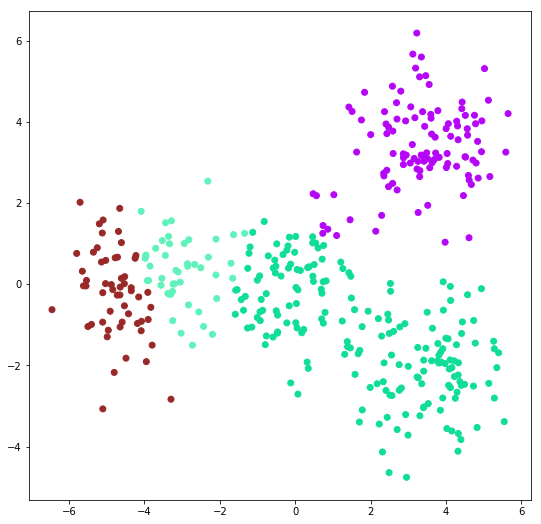

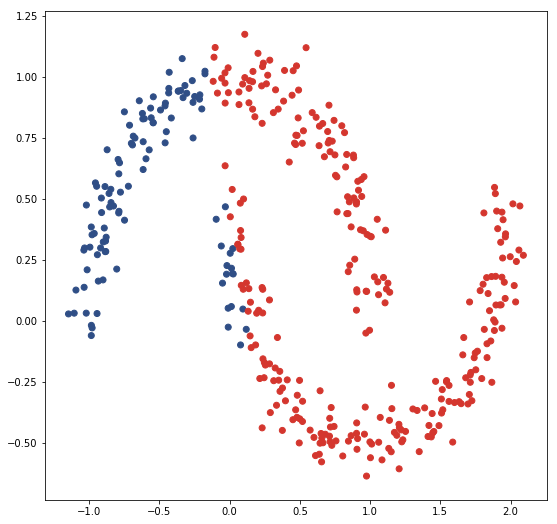

In [23]:
kmeans = KMeans(n_clusters=4, init="sample")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### 2. DBScan (3.5 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [24]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
    def fit_predict(self, X, y=None):
        y = [-1] * X.shape[0]
        unused = set(range(len(y)))

        classif = -1
        used = True
        while unused:
            if used: 
                classif += 1
            t = unused.pop()
            a = deque()
            a.append(t)
            used = False
            while a:
                el = a.pop()
                if el in unused: 
                    unused.remove(el)
                tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
                vals = tree.query_radius(X[el].reshape(1, -1), r = self.eps)[0]
                if len(vals) >= self.min_samples:
                    if classif == -1:
                        classif = 0
                    y[el] = classif
                    used = True
                    for i in vals:
                        if i in unused: a.append(i)
        tmp = len(set(y)) - 1
        y = [tmp if i == -1 else i for i in y]
                
        return y

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

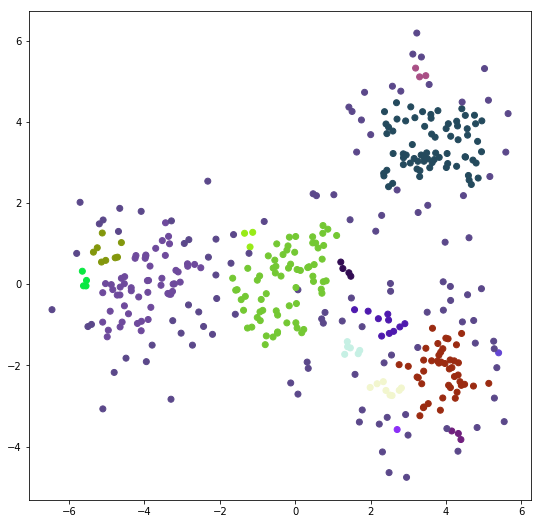

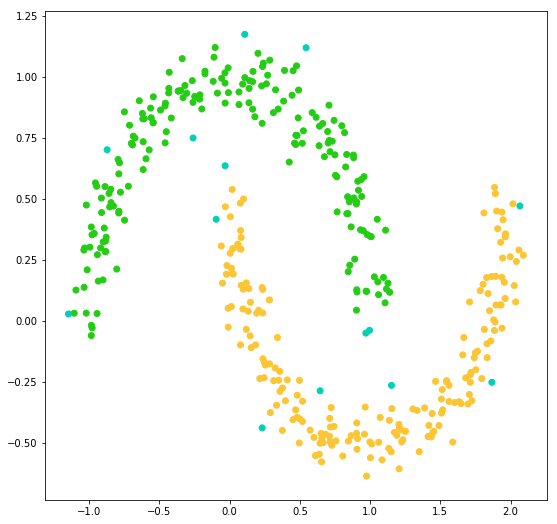

In [25]:
dbscan = DBScan(min_samples = 4, eps = 0.45)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps = 0.15)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### 3. Оценка качества моделей (1 балл)
Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

> В первой картинке K-means отработал лучше. Это ожидаемо, потому что те данные как раз хорошо под него подходят: там есть явно выраженные шарообразные кластеры. Но такой метод плохо применим для кластеров другого вида. DBScan ожидаемо справился лучше со сторой картинкой

In [26]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [27]:
# Первая картинка

kmeans = KMeans(n_clusters=4, init="sample")
kmeans.fit(X_1)
labels_k = kmeans.predict(X_1)


dbscan = DBScan(min_samples = 4, eps = 0.45)
labels_d = dbscan.fit_predict(X_1)

print("Davies-Bouldin index | K-means : ", davies_bouldin_score(X_1, labels_k))
print("Davies-Bouldin index | DBScan  : ", davies_bouldin_score(X_1, labels_d))

print()

print("Silhouette score | K-means : ", silhouette_score(X_1, labels_k))
print("Silhouette score | DBScan  : ", silhouette_score(X_1, labels_d))

Davies-Bouldin index | K-means :  0.6023655066036093
Davies-Bouldin index | DBScan  :  2.2372580279599106

Silhouette score | K-means :  0.550360201553988
Silhouette score | DBScan  :  -0.037781830926740534


> Получается, `Davies-Bouldin` меньше при лучшей кластеризации, а `Silhouette score` больше